In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
import os

from scipy.ndimage import gaussian_filter
import scipy.ndimage as ndimage

from wavefront2d.initialize import *
from wavefront2d.visualize import *
from wavefront2d.patch import *
from wavefront2d.point import *

%load_ext autoreload
%autoreload 2

## 1. Create 2D IOR field
Input is an image where grey values map to IORs.

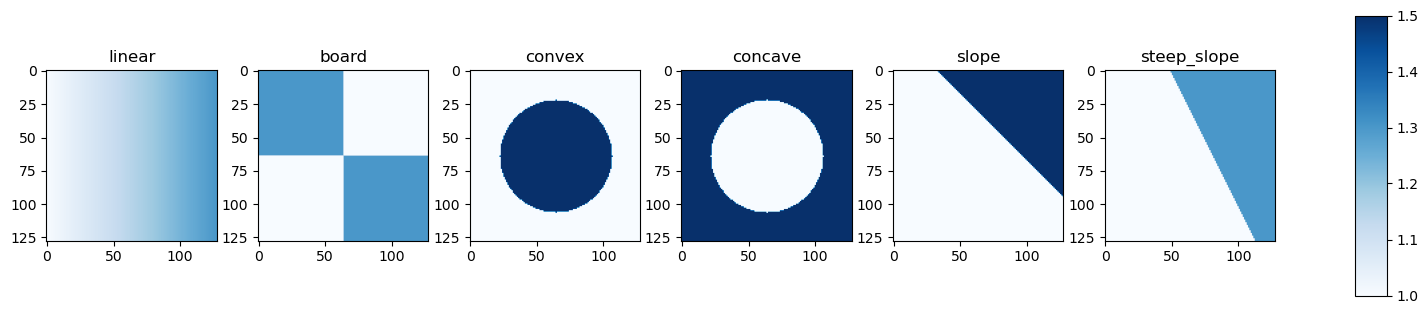

In [2]:
field_size = 128

linear_ior_field = get_ior_field("linear")
board_ior_field = get_ior_field("board")
convex_ior_field = get_ior_field("convex")
concave_ior_field = get_ior_field("concave")
slope_ior_field = get_ior_field("slope")
steep_slope_ior_field = get_ior_field("steep_slope")

# grad_x, grad_y = compute_gradients(concave_ior_field)
# visualize_gradients(grad_x, grad_y)

visualize_ior_fields([linear_ior_field, board_ior_field, convex_ior_field, concave_ior_field, slope_ior_field, steep_slope_ior_field],
                      ["linear", "board", "convex", "concave", "slope", "steep_slope"])

## 2. Adaptive wavefront propagation

In [11]:
# Initialize wavefront using Points
initial_wavefront_positions = [(0.0, float(i)) for i in range(field_size)]  # initial positions are on the left edge
initial_wavefront_directions = [(1.0, 0.0) for _ in range(field_size)]  # initial directions are all to the right

# Initialize wavefront using Patches
initial_wavefront_patches = init_wavefront_patches(initial_wavefront_positions, initial_wavefront_directions)

num_steps = int(field_size * 12)
delta_t = 0.25

# ior_field_dict = {
#     # 'linear': {'ior': linear_ior_field, 'pos': [], 'dir': [], 'patches_list': [], 
#     #            'irradiance': None, 'dir_vec': None, 'simp_irradiance': None, "mc_irradiance": None},
#     'board': {'ior': board_ior_field, 'pos': [], 'dir': [], 'patches_list': [], 
#               'irradiance': None, 'dir_vec': None, 'simp_irradiance': None, "mc_irradiance": None},
#     'convex_lens': {'ior': convex_ior_field, 'pos': [], 'dir': [], 'patches_list': [], 
#                     'irradiance': None, 'dir_vec': None, 'simp_irradiance': None, "mc_irradiance": None},
#     'concave_lens': {'ior': concave_ior_field, 'pos': [], 'dir': [], 'patches_list': [], 
#                      'irradiance': None, 'dir_vec': None, 'simp_irradiance': None, "mc_irradiance": None},
# }

ior_field_dict = {
    'board': {'ior': board_ior_field,
              'irradiance': None, "mc_irradiance": None},
    'convex_lens': {'ior': convex_ior_field,
                    'irradiance': None, "mc_irradiance": None},
    # 'concave_lens': {'ior': concave_ior_field, 
    #                  'irradiance': None, "mc_irradiance": None},
}


## 3. Simulate and Calculate irradiance $\Delta E_{\omega}$

In [ ]:
refine_threshold = 0.8

# Accumulate irradiance based on patches
for key, value in ior_field_dict.items():
    print(f"Processing {key}...")
    value["irradiance"] = accumulate_patches(value['ior'], initial_wavefront_patches, num_steps, delta_t, refine_threshold)

In [5]:
num_iterations = 10

# Accumulate irradiance based on points with Monte Carlo simulations
for key, value in ior_field_dict.items():
    print(f"Processing {key}...")
    value["mc_irradiance"] = accumulate_points_monte_carlo(
        value['ior'],
        initial_wavefront_positions,
        initial_wavefront_directions,
        num_steps,
        delta_t,
        num_simulations=num_iterations,
        perturbation_std=0.49,
        field_size=field_size
    )

Processing board...
Processing convex_lens...
Processing concave_lens...


In [18]:
import time
import numpy as np


def benchmark_optical_simulation(ior_field_dict, initial_wavefront_patches, initial_wavefront_positions, initial_wavefront_directions, num_steps, delta_t, field_size):
    results = {}
    
    # Parameters to test
    refine_thresholds = [1 - i * 0.01 for i in range(1, 10, 2)]
    num_iterations_list = [i for i in range(1, 10, 2)]
    
    for scene, ior_data in ior_field_dict.items():
        print(f"Processing {scene}...")
        results[scene] = {
            'ground_truth': None,
            'patches': [],
            'monte_carlo': []
        }
        
        # Generate ground truth with a low refine_threshold
        ground_truth_threshold = 0.2
        start_time = time.time()
        ground_truth_irradiance = accumulate_patches(ior_data['ior'], initial_wavefront_patches, num_steps, delta_t, refine_threshold=ground_truth_threshold, field_size=field_size)
        end_time = time.time()
        
        print(f"Start to generate ground truth for {scene}...")
        results[scene]['ground_truth'] = {
            'irradiance': ground_truth_irradiance,
            'time': end_time - start_time,
            'refine_threshold': ground_truth_threshold
        }
        
        # Test accumulate_patches with different refine_thresholds
        for threshold in refine_thresholds:
            print(f"Processing refine_threshold={threshold}...")
            start_time = time.time()
            irradiance = accumulate_patches(ior_data['ior'], initial_wavefront_patches, num_steps, delta_t, refine_threshold=threshold, field_size=field_size)
            end_time = time.time()
            
            results[scene]['patches'].append({
                'refine_threshold': threshold,
                'time': end_time - start_time,
                'irradiance': irradiance
            })
        
        # Test accumulate_points_monte_carlo with different num_iterations
        for num_iterations in num_iterations_list:
            print(f"Processing num_iterations={num_iterations}...")
            start_time = time.time()
            irradiance = accumulate_points_monte_carlo(
                ior_data['ior'],
                initial_wavefront_positions,
                initial_wavefront_directions,
                num_steps,
                delta_t,
                num_simulations=num_iterations,
                perturbation_std=0.49,
                field_size=field_size
            )
            end_time = time.time()
            
            results[scene]['monte_carlo'].append({
                'num_iterations': num_iterations,
                'time': end_time - start_time,
                'irradiance': irradiance
            })
    
    return results

benchmark_results = benchmark_optical_simulation(
    ior_field_dict,
    initial_wavefront_patches,
    initial_wavefront_positions,
    initial_wavefront_directions,
    num_steps,
    delta_t,
    field_size
)

Processing board...
Start to generate ground truth for board...
Processing refine_threshold=0.99...
Processing refine_threshold=0.97...
Processing refine_threshold=0.95...
Processing refine_threshold=0.9299999999999999...
Processing refine_threshold=0.91...
Processing num_iterations=1...
Processing num_iterations=3...
Processing num_iterations=5...
Processing num_iterations=7...
Processing num_iterations=9...
Processing convex_lens...
Start to generate ground truth for convex_lens...
Processing refine_threshold=0.99...
Processing refine_threshold=0.97...
Processing refine_threshold=0.95...
Processing refine_threshold=0.9299999999999999...
Processing refine_threshold=0.91...
Processing num_iterations=1...
Processing num_iterations=3...
Processing num_iterations=5...
Processing num_iterations=7...
Processing num_iterations=9...


Analysis for board:


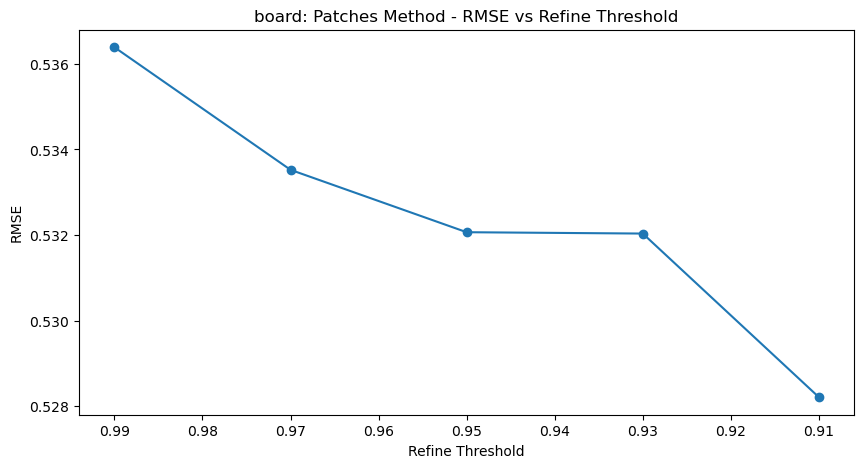

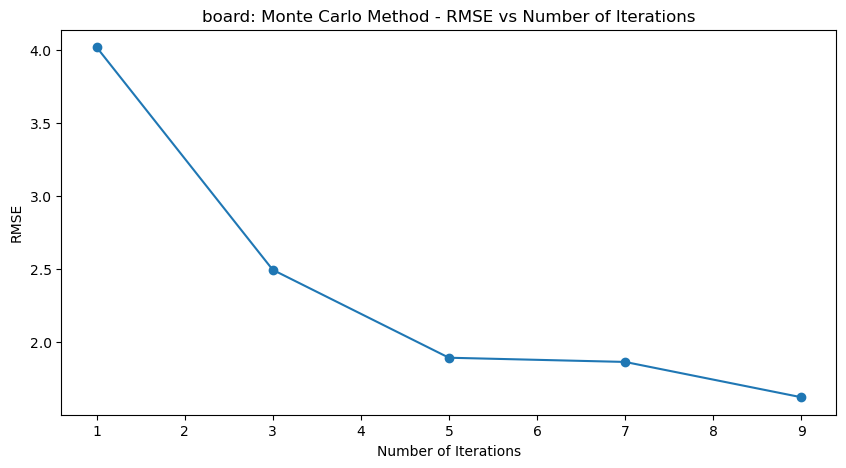

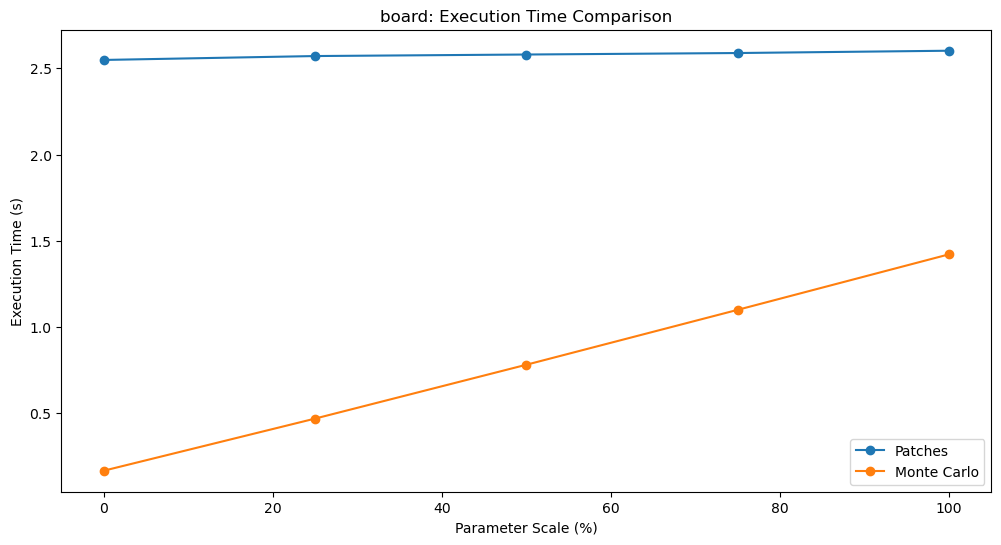

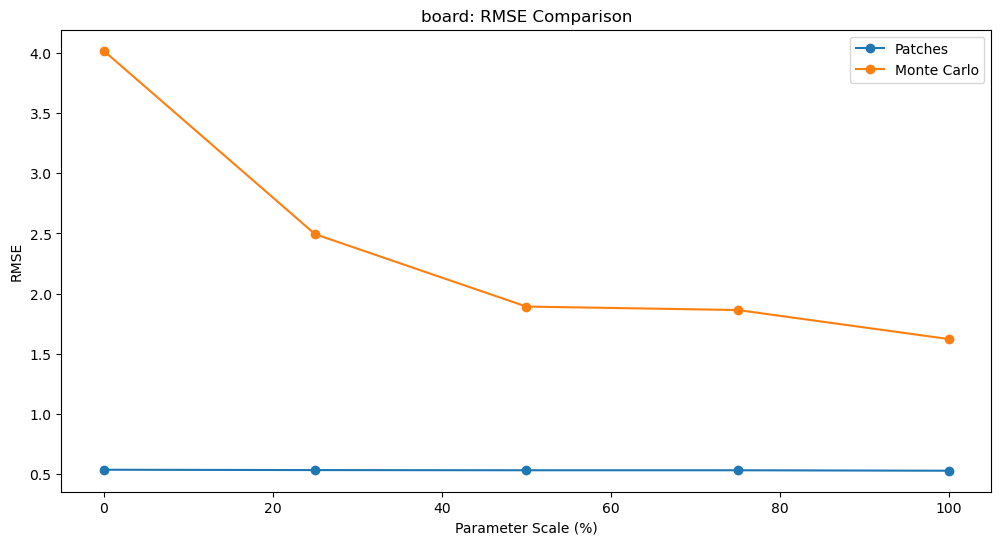

Ground Truth:
  Refine Threshold: 0.2
  Execution Time: 12.1426s

Patches method:
  Min time: 2.5485s (threshold: 0.99)
  Max time: 2.6020s (threshold: 0.91)
  Average time: 2.5781s
  Min RMSE: 0.5282 (threshold: 0.91)
  Max RMSE: 0.5364 (threshold: 0.99)

Monte Carlo method:
  Min time: 0.1670s (iterations: 1)
  Max time: 1.4218s (iterations: 9)
  Average time: 0.7879s
  Min RMSE: 1.6217 (iterations: 9)
  Max RMSE: 4.0177 (iterations: 1)


Analysis for convex_lens:


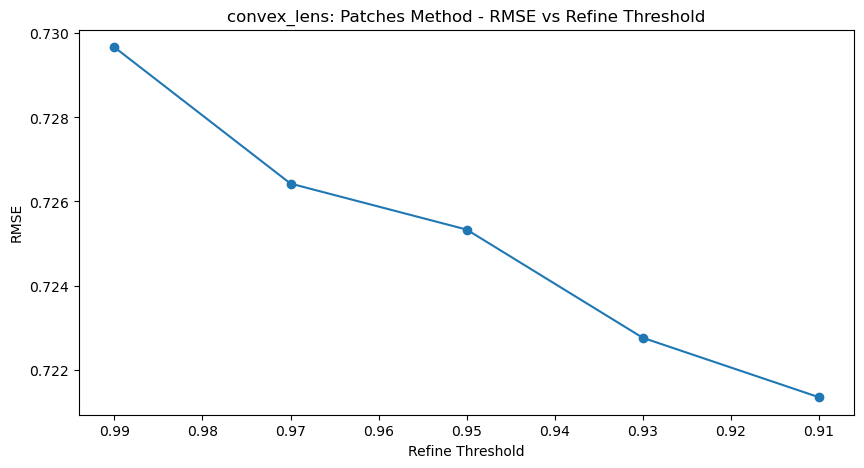

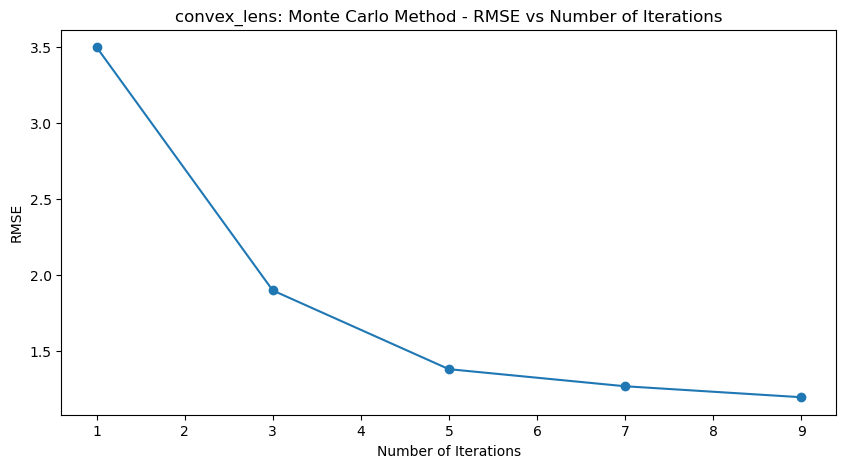

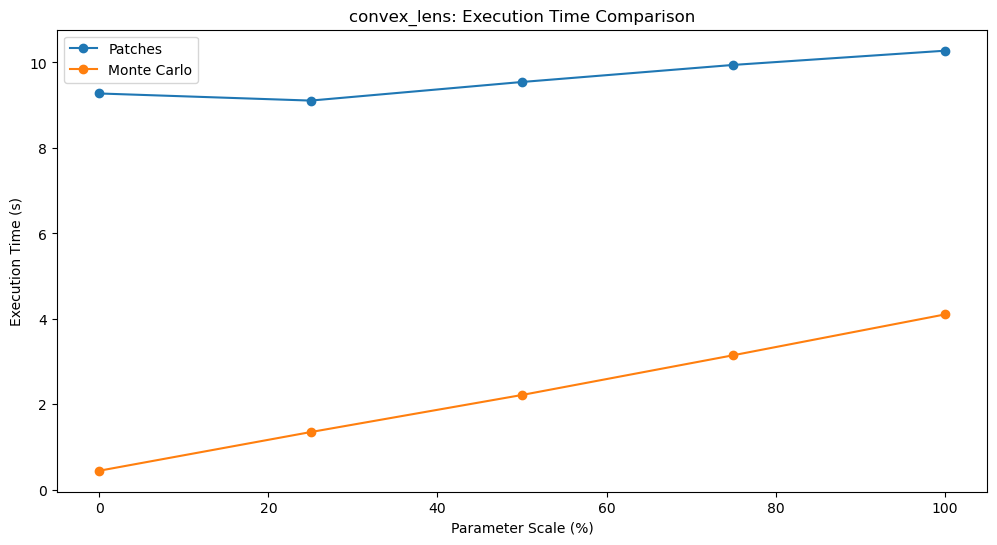

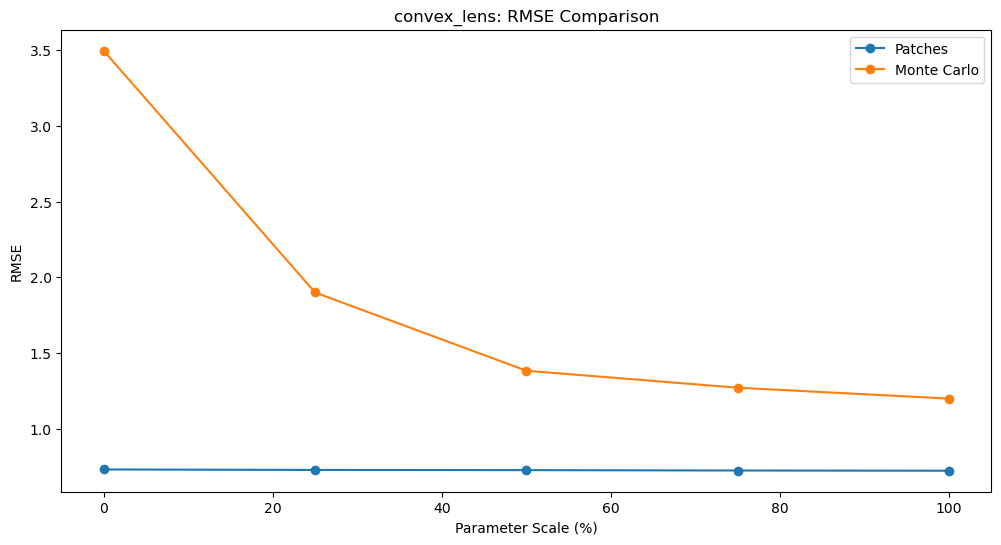

Ground Truth:
  Refine Threshold: 0.2
  Execution Time: 47.7527s

Patches method:
  Min time: 9.1078s (threshold: 0.97)
  Max time: 10.2745s (threshold: 0.91)
  Average time: 9.6284s
  Min RMSE: 0.7213 (threshold: 0.91)
  Max RMSE: 0.7297 (threshold: 0.99)

Monte Carlo method:
  Min time: 0.4476s (iterations: 1)
  Max time: 4.1034s (iterations: 9)
  Average time: 2.2546s
  Min RMSE: 1.1979 (iterations: 9)
  Max RMSE: 3.4972 (iterations: 1)




In [21]:

def calculate_rmse(ground_truth, test_irradiance):
    return np.sqrt(np.mean((ground_truth - test_irradiance) ** 2))

def plot_time_vs_parameter(x, y, title, xlabel, ylabel, invert_x=False):
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, 'o-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if invert_x:
        plt.gca().invert_xaxis()
    plt.show()

def plot_rmse_vs_parameter(x, y, title, xlabel, invert_x=False):
    plot_time_vs_parameter(x, y, title, xlabel, "RMSE", invert_x)

def plot_comparison(patch_percentages, patch_values, mc_percentages, mc_values, title, ylabel):
    plt.figure(figsize=(12, 6))
    plt.plot(patch_percentages, patch_values, 'o-', label='Patches')
    plt.plot(mc_percentages, mc_values, 'o-', label='Monte Carlo')
    plt.title(title)
    plt.xlabel("Parameter Scale (%)")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

def print_summary_statistics(data, method_name):
    times = [result['time'] for result in data]
    rmse_values = [result['rmse'] for result in data]
    parameter_name = 'threshold' if method_name == 'Patches' else 'iterations'
    parameters = [result[f'refine_{parameter_name}' if method_name == 'Patches' else 'num_iterations'] for result in data]

    print(f"\n{method_name} method:")
    print(f"  Min time: {min(times):.4f}s ({parameter_name}: {parameters[times.index(min(times))]})")
    print(f"  Max time: {max(times):.4f}s ({parameter_name}: {parameters[times.index(max(times))]})")
    print(f"  Average time: {sum(times)/len(times):.4f}s")
    print(f"  Min RMSE: {min(rmse_values):.4f} ({parameter_name}: {parameters[rmse_values.index(min(rmse_values))]})")
    print(f"  Max RMSE: {max(rmse_values):.4f} ({parameter_name}: {parameters[rmse_values.index(max(rmse_values))]})")

def analyze_benchmark_results(benchmark_results):
    for scene, data in benchmark_results.items():
        print(f"Analysis for {scene}:")
        ground_truth = data['ground_truth']['irradiance']
        
        # Prepare data
        for method in ['patches', 'monte_carlo']:
            for result in data[method]:
                result['rmse'] = calculate_rmse(ground_truth, result['irradiance'])

        patch_data = data['patches']
        mc_data = data['monte_carlo']

        # Patches method analysis
        patch_thresholds = [result['refine_threshold'] for result in patch_data]
        patch_times = [result['time'] for result in patch_data]
        patch_rmse = [result['rmse'] for result in patch_data]

        # plot_time_vs_parameter(patch_thresholds, patch_times, 
        #                        f"{scene}: Patches Method - Time vs Refine Threshold",
        #                        "Refine Threshold", "Execution Time (s)", invert_x=True)
        plot_rmse_vs_parameter(patch_thresholds, patch_rmse, 
                               f"{scene}: Patches Method - RMSE vs Refine Threshold",
                               "Refine Threshold", invert_x=True)

        # Monte Carlo method analysis
        mc_iterations = [result['num_iterations'] for result in mc_data]
        mc_times = [result['time'] for result in mc_data]
        mc_rmse = [result['rmse'] for result in mc_data]

        # plot_time_vs_parameter(mc_iterations, mc_times, 
        #                        f"{scene}: Monte Carlo Method - Time vs Number of Iterations",
        #                        "Number of Iterations", "Execution Time (s)")
        plot_rmse_vs_parameter(mc_iterations, mc_rmse, 
                               f"{scene}: Monte Carlo Method - RMSE vs Number of Iterations",
                               "Number of Iterations")

        # Compare both methods
        patch_percentages = [(max(patch_thresholds) - t) / (max(patch_thresholds) - min(patch_thresholds)) * 100 for t in patch_thresholds]
        mc_percentages = [(i - min(mc_iterations)) / (max(mc_iterations) - min(mc_iterations)) * 100 for i in mc_iterations]

        plot_comparison(patch_percentages, patch_times, mc_percentages, mc_times,
                        f"{scene}: Execution Time Comparison", "Execution Time (s)")
        plot_comparison(patch_percentages, patch_rmse, mc_percentages, mc_rmse,
                        f"{scene}: RMSE Comparison", "RMSE")

        # Print summary statistics
        print("Ground Truth:")
        print(f"  Refine Threshold: {data['ground_truth']['refine_threshold']}")
        print(f"  Execution Time: {data['ground_truth']['time']:.4f}s")

        print_summary_statistics(patch_data, "Patches")
        print_summary_statistics(mc_data, "Monte Carlo")
        print("\n")

# Run the analysis
analyze_benchmark_results(benchmark_results)

In [ ]:
# for key, value in ior_field_dict.items():
#     value["simp_irradiance"] = accumulate_points(value['ior'], initial_wavefront_positions, initial_wavefront_directions, num_steps, delta_t)

print("Irradiance computation done")

for key, value in ior_field_dict.items():
    simple_irradiance = value["mc_irradiance"]
    patches_irradiance = value["irradiance"]
    visualize_irradiance(simple_irradiance, patches_irradiance, f"Irradiance comparison for {key}")

## 4. Store irradiance into quad tree

In [ ]:
tester = "convex_lens"
test_irradiance = ior_field_dict[tester]['irradiance']

In [ ]:
class Node:
    def __init__(self, val: int = 0, top_left=None, top_right=None, bottom_left=None, bottom_right=None):
        self.val = val
        self.top_left = top_left
        self.top_right = top_right
        self.bottom_left = bottom_left
        self.bottom_right = bottom_right
    
    @property
    def is_leaf(self):
        return all(child is None for child in (self.top_left, self.top_right, self.bottom_left, self.bottom_right))
    
    def __repr__(self):
        return self._repr_recursive()

    def _repr_recursive(self, depth=0, max_depth=2):
        indent = "  " * depth
        if self.is_leaf:
            return f"{indent}Node(val={self.val})"
        else:
            if depth >= max_depth:
                return f"{indent}Node(...)"
            children_repr = ",\n".join(self._repr_recursive_child(child, depth + 1, max_depth) for child in 
                                       (self.top_left, self.top_right, self.bottom_left, self.bottom_right))
            return f"{indent}Node(\n{children_repr})"

    def _repr_recursive_child(self, child, depth, max_depth):
        return "  " * depth + "None" if child is None else child._repr_recursive(depth, max_depth)

class QuadTree:
    def __init__(self, threshold: int = 0):
        self.threshold = threshold
        self.grid_size = 0
        self.root = None
    
    def construct(self, grid: np.ndarray) -> None:
        self.root = self._build_tree(grid, 0, 0, grid.shape[0])
        self.grid_size = grid.shape[0]
    
    def _build_tree(self, grid: np.ndarray, i: int, j: int, size: int) -> Node:
        if self._is_homogeneous(grid, i, j, size):
            return Node(grid[i, j])

        half_size = size // 2
        top_left = self._build_tree(grid, i, j, half_size)
        top_right = self._build_tree(grid, i, j + half_size, half_size)
        bottom_left = self._build_tree(grid, i + half_size, j, half_size)
        bottom_right = self._build_tree(grid, i + half_size, j + half_size, half_size)
        
        if top_left.is_leaf and top_right.is_leaf and bottom_left.is_leaf and bottom_right.is_leaf:
            values = {node.val for node in (top_left, top_right, bottom_left, bottom_right)}
            if len(values) == 1:
                return Node(values.pop())
        
        return Node(top_left=top_left, top_right=top_right, bottom_left=bottom_left, bottom_right=bottom_right)
    
    def _is_homogeneous(self, grid: np.ndarray, i: int, j: int, size: int) -> bool:
        return np.ptp(grid[i:i+size, j:j+size]) <= self.threshold

    def query(self, x: int, y: int) -> int:
        return self._query(self.root, 0, 0, self.grid_size, x, y)

    def _query(self, node: Node | None, i: int, j: int, size: int, x: int, y: int) -> int:
        if node is None:
            raise ValueError("QuadTree is empty. Maybe you forgot to construct it?")
        
        if node.is_leaf:
            return node.val

        half_size = size // 2
        if x < i + half_size:
            if y < j + half_size:
                return self._query(node.bottom_left, i, j, half_size, x, y)
            else:
                return self._query(node.top_left, i, j + half_size, half_size, x, y)
        else:
            if y < j + half_size:
                return self._query(node.bottom_right, i + half_size, j, half_size, x, y)
            else:
                return self._query(node.top_right, i + half_size, j + half_size, half_size, x, y)
    
    def __len__(self):
        return self._count_nodes(self.root)
    
    def _count_nodes(self, node: Node | None) -> int:
        if node is None:
            return 0
        return 1 + sum(self._count_nodes(child) for child in 
                       (node.top_left, node.top_right, node.bottom_left, node.bottom_right))
    
    def __sizeof__(self):
        return self._calculate_memory_usage(self.root)
    
    def _calculate_memory_usage(self, node: Node | None) -> int:
        if node is None:
            return 0
        return sys.getsizeof(node) + sum(self._calculate_memory_usage(child) for child in 
                                         (node.top_left, node.top_right, node.bottom_left, node.bottom_right))
    
    def visualize(self, figsize=(20, 20)):
        plt.figure(figsize=figsize)
        self._visualize_node(self.root, 0, 0, self.grid_size)
        plt.axis('equal')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.tight_layout()
        plt.title('Quad Tree Visualization')
        plt.show()
        
    def _visualize_node(self, node: Node | None, x: float, y: float, size: float):
        if node is None:
            return
        if node.is_leaf:
            rect = patches.Rectangle((x, y), size, size, linewidth=1, edgecolor='black', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x + size / 2, y + size / 2, str(int(node.val)), ha='center', va='center', fontsize=8)
        else:
            half_size = size / 2
            self._visualize_node(node.top_left, x, y + half_size, half_size)
            self._visualize_node(node.top_right, x + half_size, y + half_size, half_size)
            self._visualize_node(node.bottom_left, x, y, half_size)
            self._visualize_node(node.bottom_right, x + half_size, y, half_size)



quad_tree = QuadTree(threshold=4) 
quad_tree.construct(test_irradiance)

value = quad_tree.query(60, 60)
print(f"Query value at (0, 99): {value}")

node_count = len(quad_tree)
print(f"Number of nodes: {node_count}")

memory_usage = sys.getsizeof(quad_tree)
print(f"Memory Usage: {memory_usage} bytes")
print(f"In comparison, NumPy Storage Usage: {test_irradiance.nbytes} bytes")

quad_tree.visualize()

In [ ]:
# plt show test_irradiance and write its each element specific int value
plt.figure(figsize=(20, 20))
plt.imshow(test_irradiance, cmap='hot', interpolation='nearest')
for i in range(test_irradiance.shape[0]):
    for j in range(test_irradiance.shape[1]):
        plt.text(j, i, str(int(test_irradiance[i, j])), ha='center', va='center', color='black', fontsize=7)
plt.colorbar(label='Irradiance')
plt.title('Test Irradiance')
plt.show()